In [1]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import plotly.express as px
from configuration.config import DATA_PATH

In [3]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

## Tracking Scoring Metrics for Models

In [4]:
model_scores = pd.DataFrame({
                             'model_type':[],
                             'train_test_split':[],
                             'is_pca':[], 
                             'score_rmse':[],
                             'score_mae':[], 
                             'score_r2':[],
                             'cv_mean_r2':[],
                             'cv_std_r2':[],
                             'cv_mean_rmse':[],
                             'cv_std_rmse':[],
                             'cv_mean_mae':[],
                             'cv_std_mae':[],
                             'best_params':[] 
                            })
model_scores

,model_type,train_test_split,is_pca,score_rmse,score_mae,score_r2,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params


In [5]:
def add_model_score(model_type, train_test_split, is_pca, score_rmse, score_mae, score_r2, cv_mean_r2, cv_std_r2, cv_mean_rmse, cv_std_rmse, cv_mean_mae, cv_std_mae, best_params=None):
    """
    Adds a row to the model_scores DataFrame with the specified model performance metrics.

    Parameters:
        model_scores (pd.DataFrame): DataFrame to log the results.
        model_type (str): Type of the model.
        train_test_split (str): Description of the data split used.
        is_pca (bool): Indicates if PCA was applied.
        score_rmse (float): Root Mean Squared Error of the model.
        score_mae (float): Mean Absolute Error of the model.
        score_r2 (float): R2 Score of the model.
        cross_val_mean (float): Mean of cross-validation scores.
        cross_val_std (float): Standard deviation of cross-validation scores.
        best_params (dict): Best parameters from model tuning.

    Returns:
        pd.DataFrame: Updated DataFrame with the new model scores.
    """
    global model_scores

    new_row = {
    'model_type': model_type,
    'train_test_split': train_test_split,
    'is_pca': is_pca,
    'score_rmse': score_rmse,
    'score_mae': score_mae,
    'score_r2': score_r2,
    'cv_mean_r2': cv_mean_r2,
    'cv_std_r2': cv_std_r2,
    'cv_mean_rmse': cv_mean_rmse,
    'cv_std_rmse': cv_std_rmse,
    'cv_mean_mae': cv_mean_mae,
    'cv_std_mae': cv_std_mae,
    'best_params': best_params
    }

    model_scores.loc[len(model_scores)] = new_row

# Modeling

## I. Reduced & Robust Scaled Data


In [6]:
# import train/test splits for modeling the reduced and robust scaled data
X_train = pd.read_csv(DATA_PATH + 'modeling/X_train_reduced_robust.csv')
X_test = pd.read_csv(DATA_PATH + 'modeling/X_test_reduced_robust.csv')
y_train = pd.read_csv(DATA_PATH + 'modeling/y_train_data.csv').values.ravel()
y_test = pd.read_csv(DATA_PATH + 'modeling/y_test_data.csv').values.ravel()

In [7]:
X_train.shape, y_train.shape

((957, 55), (957,))

In [8]:
X_test.shape, y_test.shape

((411, 55), (411,))

### A. Linear Regression

In [9]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

cv_results_r2 = cross_val_score(linear_model, X_train, y_train, scoring='r2', cv=kf)

# Print results
print("CV Scores (R²):", cv_results_r2)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train, y_train, scoring=score, cv=kf)
    #mean_type = str('cv_mean' + score)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


CV Scores (R²): [0.63272961 0.53134321 0.61845087 0.57553375 0.59681083]


{'r2': (0.5909736545219626, 0.035571926740887605),
 'neg_mean_squared_error': (-2945996035858.7866, 728215652248.6544),
 'neg_mean_absolute_error': (-1138616.3787951702, 106621.84867873251)}

In [10]:
linear_model.fit(X_train, y_train)
score = linear_model.score(X_test, y_test)
y_pred = linear_model.predict(X_test)

In [11]:
rmse = root_mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'R2 Score: {score}, Root Mean Squared Error: {rmse}, Mean Absolute Error: {mae}')

R2 Score: 0.648107335705167, Root Mean Squared Error: 1695937.3394324314, Mean Absolute Error: 1182456.09202045


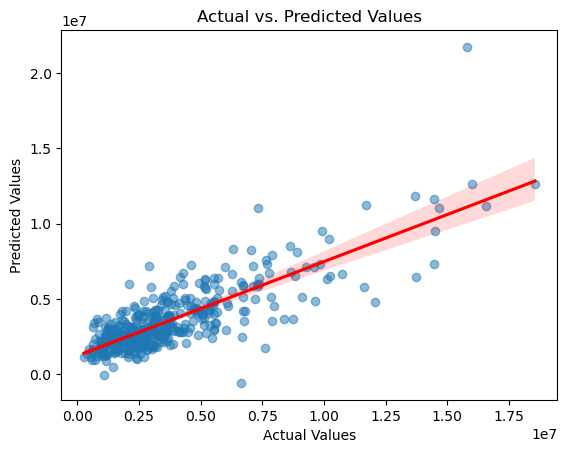

In [12]:
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [13]:
add_model_score('Linear Regression', 'reduced_robust', False, rmse, mae, score,
                               scores['r2'][0], scores['r2'][1], 
                               scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                               scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

In [14]:
model_scores

,model_type,train_test_split,is_pca,score_rmse,score_mae,score_r2,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Linear Regression,reduced_robust,False,1.695937e+06,1.182456e+06,0.648107,0.590974,0.035572,-2.945996e+12,7.282157e+11,-1.138616e+06,106621.848679,None


**Linear Regression Results**


#### Linear Regression with PCA

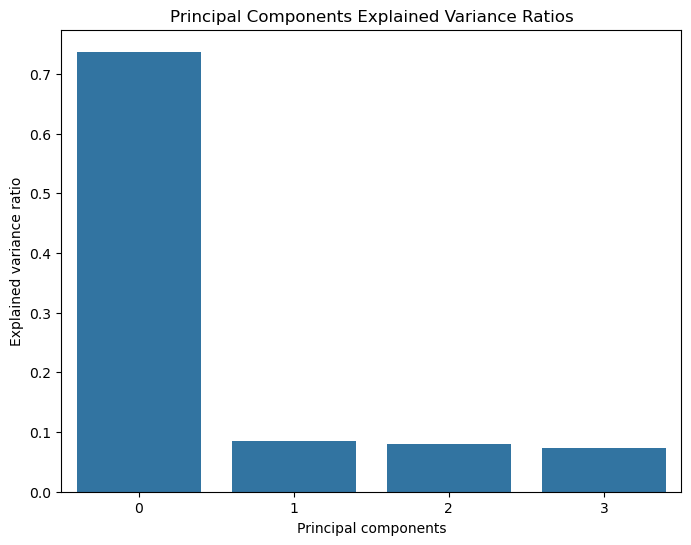

                             PC 1      PC 2      PC 3      PC 4
public_insurance         0.974435 -0.129551 -0.025591 -0.177609
public_insurance_ratio   0.220433  0.679798  0.121358  0.687655
migrant_patients         0.027424 -0.593294 -0.426182  0.656331
lep_patients             0.012654 -0.036021  0.010973  0.014287
hispanic_any_race        0.011357 -0.047122  0.014922  0.025301
total_other_revenue      0.010359 -0.385242  0.892319  0.223647
uninsured                0.009267 -0.020235 -0.001584  0.004288
homeless_patients        0.008020 -0.027518  0.002427  0.008732
total_patients           0.007583 -0.025995  0.006099  0.008405
total_grant_funding      0.007404 -0.017753  0.010561  0.002050
total_0_17               0.007403 -0.024589  0.007277  0.008726
public_housing_patients  0.007383 -0.026459 -0.010788  0.011953
low_income               0.007287 -0.027430  0.006552  0.010520
fpl_unknown              0.006981 -0.016700  0.007734  0.000646
total_18_up              0.006897 -0.024

In [15]:
# create PCA object
pca = PCA(n_components=4)

pca.fit(X_train)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4'], 
                        index=X_train.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [16]:
linear_model = LinearRegression()
linear_model.fit(X_train_pca, y_train)
linear_model.score(X_test_pca, y_test)

0.25230508735442503

### B. Random Forest Regression

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train, y_train)

y_pred = rf_gridsearch.predict(X_test)

In [18]:
print(rf_gridsearch.score(X_test, y_test))
print(rf_gridsearch.best_params_)

0.652278656381984
{'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 10, 'n_estimators': 50, 'n_jobs': -1}


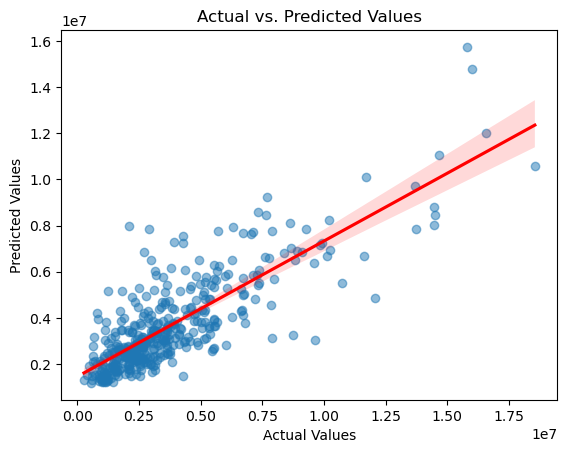

In [19]:
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [20]:
rf_model = RandomForestRegressor(
    criterion='squared_error',
    max_depth=None,
    max_features=None,
    n_estimators=200,
    n_jobs=1)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rf_model.score(X_test, y_test)

0.6693549204302098

In [21]:
rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train.columns)
rf_important_features.sort_values('feature_importance', ascending=False).head(15)

,feature_importance
total_patients,0.208578
total_18_up,0.198267
uninsured,0.112738
TotalWeeklyHoursOfOperation,0.057118
medicaid,0.031420
low_income,0.027938
homeless_patients,0.023097
hispanic_any_race,0.022533
diverse_race_proportion,0.021448
diverse_patients_sum,0.016301


## II. Reduced & Power Transformed Data

In [22]:
# import train/test splits for modeling the reduced and power transformed data
X_train = pd.read_csv(DATA_PATH + 'modeling/X_train_reduced_power.csv')
X_test = pd.read_csv(DATA_PATH + 'modeling/X_test_reduced_power.csv')
y_train = pd.read_csv(DATA_PATH + 'modeling/y_train_data.csv').values.ravel()
y_test = pd.read_csv(DATA_PATH + 'modeling/y_test_data.csv').values.ravel()

### A. Linear Regression

In [23]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

cv_results_r2 = cross_val_score(linear_model, X_train, y_train, scoring='r2', cv=kf)

# Print results
print("CV Scores (R²):", cv_results_r2)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train, y_train, scoring=score, cv=kf)
    #mean_type = str('cv_mean' + score)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


CV Scores (R²): [0.62473692 0.63010138 0.66136291 0.53950167 0.53946945]


{'r2': (0.5990344636795605, 0.050205076251924156),
 'neg_mean_squared_error': (-2808687788002.935, 294665187913.302),
 'neg_mean_absolute_error': (-1178158.8913426977, 48396.079775737315)}

In [24]:
linear_model.fit(X_train, y_train)
score = linear_model.score(X_test, y_test)
y_pred = linear_model.predict(X_test)

In [25]:
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'R2 Score: {score}, Root Mean Squared Error: {rmse}, Mean Absolute Error: {mae}')

R2 Score: 0.6309846588916438, Root Mean Squared Error: 1736708.405242719, Mean Absolute Error: 1238074.0153439895


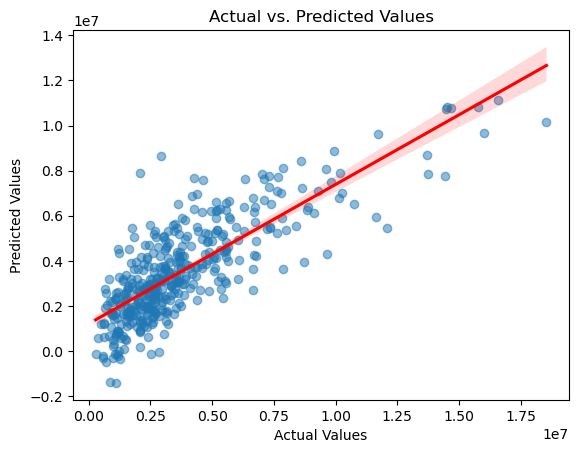

In [26]:
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [27]:
add_model_score('Linear Regression', 'reduced_power', False, rmse, mae, score,
                               scores['r2'][0], scores['r2'][1], 
                               scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                               scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

#### Linear Regression with PCA

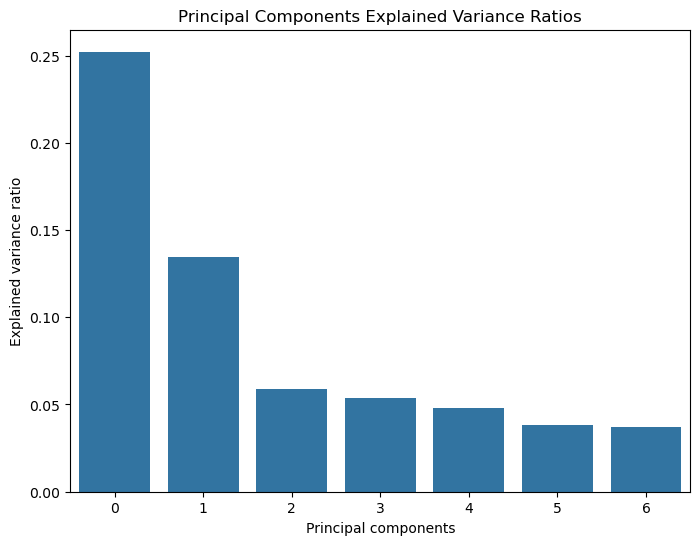

                                 PC 1      PC 2      PC 3      PC 4      PC 5  \
total_patients               0.258744  0.057893 -0.000676 -0.020337 -0.063893   
total_18_up                  0.254590  0.065198 -0.006967  0.011598 -0.048382   
medicaid                     0.245599  0.018039 -0.064310 -0.068371 -0.050161   
total_0_17                   0.237901  0.053391  0.038473 -0.090392 -0.099393   
low_income                   0.236474 -0.053146 -0.008817  0.112412 -0.177707   
hispanic_any_race            0.218171 -0.123179  0.175528 -0.042909  0.054906   
total_grant_funding          0.216436 -0.027588 -0.011801 -0.043726  0.034644   
TotalWeeklyHoursOfOperation  0.213104  0.081410 -0.048302  0.103900 -0.044691   
uninsured                    0.212744 -0.075911  0.103544  0.059210 -0.014241   
lep_patients                 0.206383 -0.150711  0.151784 -0.097013  0.047141   
ZipCode_Count                0.203369  0.010612 -0.061875 -0.038893 -0.066854   
total_sites                 

In [28]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [29]:
linear_model = LinearRegression()
linear_model.fit(X_train_pca, y_train)
linear_model.score(X_test_pca, y_test)

0.567927475374539

### Random Forest Regressor with GridSearch

In [30]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train, y_train)

y_pred = rf_gridsearch.predict(X_test)

rf_gridsearch.score(X_test, y_test)

0.6639503756565042

In [31]:
print(rf_gridsearch.score(X_test, y_test))
print(rf_gridsearch.best_params_)


0.6639503756565042
{'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 10, 'n_estimators': 100, 'n_jobs': -1}


In [32]:
rf_model = RandomForestRegressor(
    criterion='friedman_mse',
    max_depth=None,
    max_features=None,
    n_estimators=200,
    n_jobs=1)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rf_model.score(X_test, y_test)

0.6660607856801976

In [33]:
rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train.columns)
rf_important_features.sort_values('feature_importance', ascending=False).head(15)

,feature_importance
total_patients,0.261731
total_18_up,0.178047
uninsured,0.090755
TotalWeeklyHoursOfOperation,0.042128
medicaid,0.034672
low_income,0.029703
hispanic_any_race,0.020884
homeless_patients,0.020335
diverse_race_proportion,0.020010
diverse_patients_sum,0.017598


## III. Imputed & Robust Scaled Data

In [34]:
# import train/test splits for modeling the imputed and robust scaled data
X_train = pd.read_csv(DATA_PATH + 'modeling/X_train_imputed_robust.csv')
X_test = pd.read_csv(DATA_PATH + 'modeling/X_test_imputed_robust.csv')
y_train = pd.read_csv(DATA_PATH + 'modeling/y_train_data.csv').values.ravel()
y_test = pd.read_csv(DATA_PATH + 'modeling/y_test_data.csv').values.ravel()

### A. Linear Regression

In [35]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

cv_results_r2 = cross_val_score(linear_model, X_train, y_train, scoring='r2', cv=kf)

# Print results
print("CV Scores (R²):", cv_results_r2)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train, y_train, scoring=score, cv=kf)
    #mean_type = str('cv_mean' + score)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


CV Scores (R²): [0.66132926 0.54079383 0.59973283 0.58783124 0.57823359]


{'r2': (0.5935841497968134, 0.039198876371561095),
 'neg_mean_squared_error': (-2925900924249.208, 733482917895.5719),
 'neg_mean_absolute_error': (-1142219.837240419, 113015.29384614581)}

In [36]:
linear_model.fit(X_train, y_train)
score = linear_model.score(X_test, y_test)
y_pred = linear_model.predict(X_test)

In [37]:
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'R2 Score: {score}, Root Mean Squared Error: {rmse}, Mean Absolute Error: {mae}')

R2 Score: 0.6611247898199204, Root Mean Squared Error: 1664273.1067149616, Mean Absolute Error: 1160004.3622089587


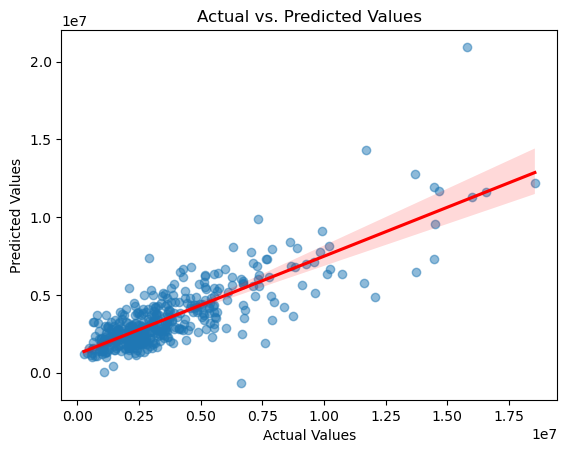

In [38]:
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [39]:
add_model_score('Linear Regression', 'imputed_robust', False, rmse, mae, score,
                               scores['r2'][0], scores['r2'][1], 
                               scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                               scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### B. Random Forest Regressor

In [40]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train, y_train)

y_pred = rf_gridsearch.predict(X_test)

print(rf_gridsearch.score(X_test, y_test))
print(rf_gridsearch.best_params_)

0.6615519063875059
{'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50, 'n_jobs': -1}


In [41]:
rf_model = RandomForestRegressor(
    criterion='squared_error',
    max_depth=None,
    max_features=None,
    n_estimators=50,
    n_jobs=1)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rf_model.score(X_test, y_test)

0.6612663723668719

In [42]:
rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train.columns)
rf_important_features.sort_values('feature_importance', ascending=False).head(15)

,feature_importance
total_patients,0.213298
total_18_up,0.140490
uninsured,0.123668
total_cost_care,0.039936
TotalWeeklyHoursOfOperation,0.038011
medicaid,0.035524
low_income,0.031448
total_visits,0.030168
hispanic_any_race,0.018756
diverse_race_proportion,0.017506


## IV. Imputed & Power Transformed Data

### A. Linear Regression

In [43]:
# import train/test splits for modeling the imputed and power transformed data
X_train = pd.read_csv(DATA_PATH + 'modeling/X_train_imputed_power.csv')
X_test = pd.read_csv(DATA_PATH + 'modeling/X_test_imputed_power.csv')
y_train = pd.read_csv(DATA_PATH + 'modeling/y_train_data.csv').values.ravel()
y_test = pd.read_csv(DATA_PATH + 'modeling/y_test_data.csv').values.ravel()

In [44]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

cv_results_r2 = cross_val_score(linear_model, X_train, y_train, scoring='r2', cv=kf)

# Print results
print("CV Scores (R²):", cv_results_r2)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train, y_train, scoring=score, cv=kf)
    #mean_type = str('cv_mean' + score)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


CV Scores (R²): [0.63430942 0.62573718 0.66938503 0.55599678 0.56586427]


{'r2': (0.610258535920647, 0.04296315888989285),
 'neg_mean_squared_error': (-2741680922173.4883, 350562355527.1881),
 'neg_mean_absolute_error': (-1171778.2785582046, 54307.039607582075)}

In [45]:
linear_model.fit(X_train, y_train)
score = linear_model.score(X_test, y_test)
y_pred = linear_model.predict(X_test)

In [46]:
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'R2 Score: {score}, Root Mean Squared Error: {rmse}, Mean Absolute Error: {mae}')

R2 Score: 0.6358492611841725, Root Mean Squared Error: 1725223.2136154273, Mean Absolute Error: 1231267.7984675933


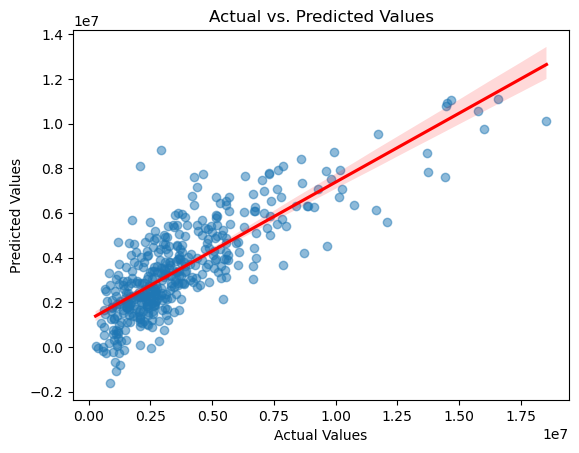

In [47]:
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [48]:
add_model_score('Linear Regression', 'imputed_power', False, rmse, mae, score,
                               scores['r2'][0], scores['r2'][1], 
                               scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                               scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### B. Random Forest Regressor

In [49]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train, y_train)

y_pred = rf_gridsearch.predict(X_test)

In [50]:
print(rf_gridsearch.score(X_test, y_test))
print(rf_gridsearch.best_params_)

0.668254721127745
{'criterion': 'squared_error', 'max_depth': 10, 'max_features': 20, 'n_estimators': 100, 'n_jobs': -1}


In [51]:
rf_model = RandomForestRegressor(
    criterion='squared_error',
    max_depth=None,
    max_features=None,
    n_estimators=50,
    n_jobs=1)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rf_model.score(X_test, y_test)

0.6644700856618743

In [52]:
rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train.columns)
rf_important_features.sort_values('feature_importance', ascending=False).head(15)

,feature_importance
total_patients,0.184661
total_18_up,0.172721
uninsured,0.097479
total_cost_care,0.059776
TotalWeeklyHoursOfOperation,0.054083
medicaid,0.025118
low_income,0.024924
total_visits,0.022790
diverse_race_proportion,0.019617
total_0_17,0.018084


# Scores Analysis

In [53]:
model_scores.sort_values('cv_mean_r2',ascending=False)

,model_type,train_test_split,is_pca,score_rmse,score_mae,score_r2,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
3,Linear Regression,imputed_power,False,1.725223e+06,1.231268e+06,0.635849,0.610259,0.042963,-2.741681e+12,3.505624e+11,-1.171778e+06,54307.039608,None
1,Linear Regression,reduced_power,False,1.736708e+06,1.238074e+06,0.630985,0.599034,0.050205,-2.808688e+12,2.946652e+11,-1.178159e+06,48396.079776,None
2,Linear Regression,imputed_robust,False,1.664273e+06,1.160004e+06,0.661125,0.593584,0.039199,-2.925901e+12,7.334829e+11,-1.142220e+06,113015.293846,None
0,Linear Regression,reduced_robust,False,1.695937e+06,1.182456e+06,0.648107,0.590974,0.035572,-2.945996e+12,7.282157e+11,-1.138616e+06,106621.848679,None
